# Validation for quantile delta change 

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/rcp85/r1i1p1/day/tasmin/v20120407/tasmin-qdc-additive-monthly-adjustment-factors_CanESM2_rcp85_r1i1p1_20560101-20851231_wrt_19860101-20051231.nc"
qq_file = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/rcp85/r1i1p1/day/tasmin/v20120407/tasmin_day_CanESM2_rcp85_r1i1p1_AUS-r005_20560101-20851231_qdc-additive-monthly_AGCD-19810101-20101231_historical-19860101-20051231_mean-match.nc"
kim_qq_file = "/g/data/wp00/data/QQ-CMIP5/CanESM2/tasmin/rcp85/2056-2085/tasmin_AUS_CanESM2_rcp85_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 5
hist_units = "K"
ref_units = "K"
target_units = "C"
output_units = "C"
hist_var = "tasmin"
ref_var = "tasmin"
target_var = "tmin"
hist_files = "/g/data/al33/replicas/CMIP5/combined/CCCma/CanESM2/historical/day/atmos/day/r1i1p1/v20120410/tasmin/tasmin_day_CanESM2_historical_r1i1p1_19790101-20051231.nc"
ref_files = "/g/data/al33/replicas/CMIP5/combined/CCCma/CanESM2/rcp85/day/atmos/day/r1i1p1/v20120407/tasmin/tasmin_day_CanESM2_rcp85_r1i1p1_20060101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/tmin/daily/tmin_AGCD-CSIRO_r005_19100101-20220405_daily_space-chunked.zarr"
target_q_file = "/g/data/wp00/data/AGCD/tmin-quantiles_AGCD_r005_1981-2010_daily.nc"
hist_time_bounds = "1986-01-01 2005-12-31"
ref_time_bounds = "2056-01-01 2085-12-31"
target_time_bounds = "1981-01-01 2010-12-31"


In [5]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'target_q_file' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [7]:
point_selection = {'lat': example_lat, 'lon': example_lon}

In [8]:
plot_config = {}
if hist_var == 'tasmin':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
elif hist_var == 'tasmax':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var == 'pr':
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

## Read data

In [9]:
ds_adjust = xr.open_dataset(adjustment_file)

In [10]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)
ds_hist[hist_var]

<xarray.DataArray 'tasmin' (time: 7300, lat: 64, lon: 128)>
dask.array<xarray-tasmin, shape=(7300, 64, 128), dtype=float32, chunksize=(7300, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1986-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Minimum Near-Surface Air Temperature
    units:             C
    original_name:     STMN
    cell_methods:      time: minimum (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-04-14T22:34:59Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [11]:
da_hist_point = ds_hist[hist_var].sel(point_selection, method='nearest')
hist_q_point_annual = utils.get_quantiles(da_hist_point, ds_adjust['quantiles'].data, timescale='annual')
da_hist_point_month = da_hist_point[da_hist_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  0.1s


In [12]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)
ds_ref[ref_var]

<xarray.DataArray 'tasmin' (time: 10950, lat: 64, lon: 128)>
dask.array<xarray-tasmin, shape=(10950, 64, 128), dtype=float32, chunksize=(10950, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2056-01-01 12:00:00 ... 2085-12-31 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Minimum Near-Surface Air Temperature
    units:             C
    original_name:     STMN
    cell_methods:      time: minimum (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-04-10T11:25:57Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [13]:
da_ref_point = ds_ref[ref_var].sel(point_selection, method='nearest')
ref_q_point_annual = utils.get_quantiles(da_ref_point, ds_adjust['quantiles'].data, timescale='annual')
da_ref_point_month = da_ref_point[da_ref_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  0.1s


In [14]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)
ds_target[target_var]

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray 'tmin' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-tmin, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1981-01-01T09:00:00 ... 2010-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:47:23 UTC
    analysis_version_number:    2.01
    cell_methods:               time: minimum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily minimum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      C

In [15]:
da_target_point = ds_target[target_var].sel(point_selection, method='nearest')
target_q_point_annual = utils.get_quantiles(da_target_point, ds_adjust['quantiles'].data, timescale='annual')
da_target_point_month = da_target_point[da_target_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  0.1s


In [16]:
target_q = xr.open_dataset(target_q_file)
target_q

<xarray.Dataset>
Dimensions:    (quantiles: 100, lon: 886, lat: 691, month: 12)
Coordinates:
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
  * lon        (lon) float64 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tmin       (quantiles, month, lat, lon) float32 ...
Attributes:
    history:  Thu Mar 16 13:05:39 2023: /g/data/xv83/dbi599/miniconda3/envs/q...

In [17]:
ds_qq = xr.open_dataset(qq_file)

In [18]:
da_qq_point = ds_qq[target_var].sel(point_selection, method='nearest')
qq_q_point_annual = utils.get_quantiles(da_qq_point, ds_adjust['quantiles'].data, timescale='annual')
da_qq_point_month = da_qq_point[da_qq_point['time'].dt.month == example_month]

In [19]:
ds_kim_qq = xr.open_dataset(kim_qq_file)

In [20]:
da_kim_qq_point = ds_kim_qq[ref_var].sel(point_selection, method='nearest')
kim_qq_q_point_annual = utils.get_quantiles(da_kim_qq_point, ds_adjust['quantiles'].data, timescale='annual')
da_kim_qq_point_month = da_kim_qq_point[da_kim_qq_point['time'].dt.month == example_month]

In [21]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [22]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

## QQ-scaled data

In [23]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [24]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)
kim_qq_clim = ds_kim_qq[hist_var].mean('time', keep_attrs=True)

In [25]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)
    
if len(target_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(target_clim, qq_clim, "bilinear")
    target_clim = regridder(target_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

In [26]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed |  0.8s


In [27]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  9min 28.3s


In [28]:
difference = qq_mean_change - hist_ref_mean_diff

In [29]:
kim_qq_mean_change = kim_qq_clim - target_clim
kim_qq_mean_change = kim_qq_mean_change.compute()

[########################################] | 100% Completed |  2min 12.7s


In [30]:
kim_difference = kim_qq_mean_change - hist_ref_mean_diff

In [31]:
new_old_qq_difference = qq_mean_change - kim_qq_mean_change

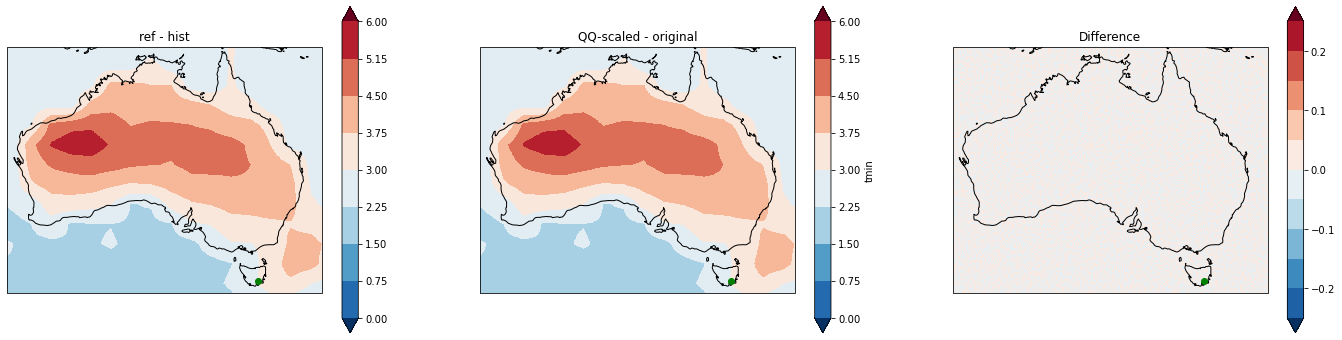

In [32]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25],
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

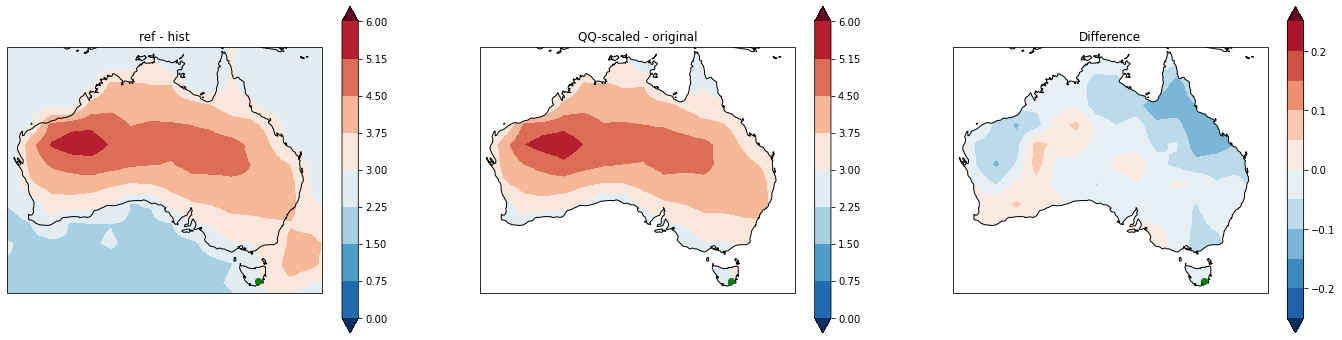

In [33]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
kim_qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
kim_difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25],
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

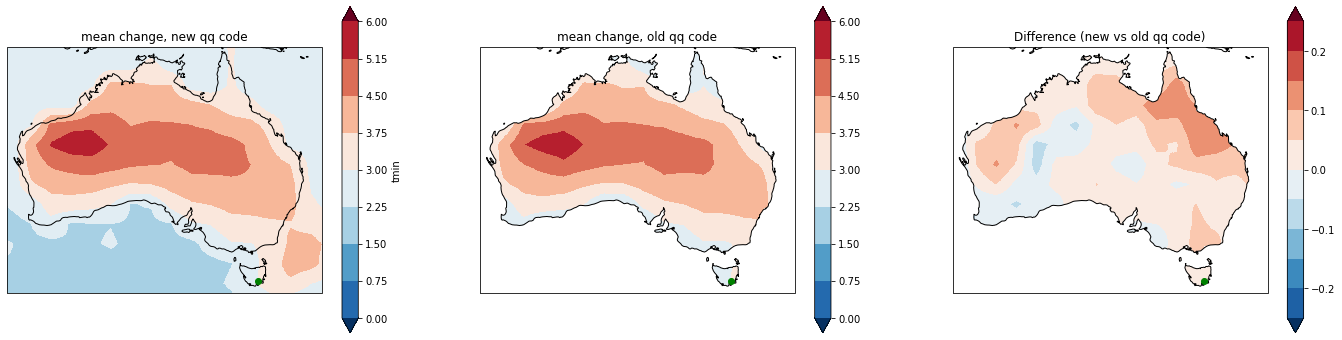

In [34]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax1.set_title('mean change, new qq code')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
kim_qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.15, 6.0],
    extend='both'
)
ax2.set_title('mean change, old qq code')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
new_old_qq_difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25],
    extend='both'
)
ax3.set_title('Difference (new vs old qq code)')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

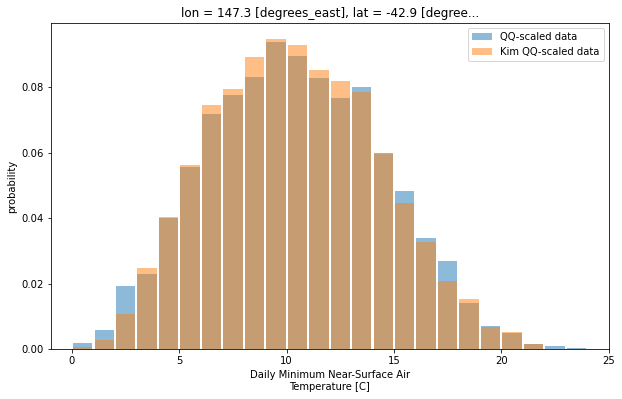

In [38]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)
    
#da_target_point.plot.hist(
#    bins=bins,
#    density=True,
#    label='observations',
#    facecolor='tab:blue',
#    alpha=0.5,
#    rwidth=0.9,
#)
da_qq_point.plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
da_kim_qq_point.plot.hist(
    bins=bins,
    density=True,
    label='Kim QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
#plt.ylim(0, 0.005)
plt.xlim(-1, 25)
plt.legend()
plt.show()

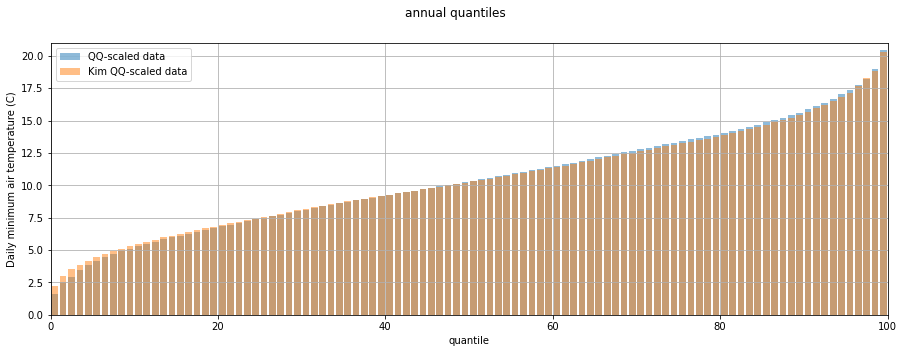

In [36]:
fig = plt.figure(figsize=[15, 5])
ax1 = fig.add_subplot(111)

qq_data = qq_q_point_annual.values
kim_qq_data = kim_qq_q_point_annual.values
quantiles = target_q_point_annual['quantiles'].data * 100
    
ax1.bar(quantiles, qq_data, alpha=0.5, color='tab:blue', label='QQ-scaled data')
ax1.bar(quantiles, kim_qq_data, alpha=0.5, color='tab:orange', label='Kim QQ-scaled data')

ylabel = f"""{da_target_point.attrs['long_name']} ({da_target_point.attrs['units']})"""

ax1.set_xlim(0, 100)
ax1.set_ylim(0, 21)
ax1.grid()
ax1.legend()
ax1.set_xlabel('quantile')
ax1.set_ylabel(ylabel)

plt.suptitle('annual quantiles')
plt.show()